# Performance analysis
In this notebook we analyzes the performance of the graph network in clustering and classifying the jets

In [1]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dgl.nn import NNConv, EdgeConv
from dgl.nn.pytorch import Sequential as dglSequential
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

## Define model and load it

In [24]:
class GraphDataset(Dataset):
    def __init__(self, data_path, n_files=None, lbl_to_load=None, transform=None):

        self.fnames    = [fname for fname in os.listdir(data_path) if fname.endswith('.dgl')]
        self.data_path = data_path

        if n_files:
            self.fnames = self.fnames[n_files]

        self.transform = transform     
        self.lbl_2_load = lbl_to_load

        self.load_graphs()


    def load_graphs(self):
        self.graphs = []

        for fname in tqdm(self.fnames, 'Reading files'):
            graphs, _ = dgl.load_graphs(os.path.join(self.data_path, fname))
            if self.lbl_2_load:
                self.graphs.extend([graph for graph in graphs if graph.ndata['labels'][0].nonzero().squeeze() in self.lbl_2_load])
            else:
                self.graphs.extend(graphs)


    def __len__(self):

        return len(self.graphs)
    

    def __getitem__(self, idx):

        x = self.graphs[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, latent_space_dim, ch=[256,128,64,32]):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.Linear(3, ch[0]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[0],ch[1]),
            nn.Dropout(0.2),
            nn.ReLU(),
            
            nn.Linear(ch[1],ch[2]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[2], ch[3]),
            nn.Dropout(0.2),
            nn.ReLU(),

            nn.Linear(ch[3], 7*128),
            nn.Sigmoid()
            )
        
        self.conv = dglSequential(
            NNConv(
                in_feats  = 7,  # number of node features
                out_feats = 128, # output number of node features
                edge_func = self.mlp),
            EdgeConv(128, 64, batch_norm=True),
            EdgeConv(64, 32, batch_norm=True),
            EdgeConv(32, latent_space_dim, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):

        x = self.conv(graph, n_feat if n_feat else graph.ndata['f'], graph.edata['d'])
        return x
    

class Decoder(nn.Module):
    
    def __init__(self, latent_space_dim, n_feat=7):
        super().__init__()

        self.shared_path = dglSequential(
            EdgeConv(latent_space_dim, 32, batch_norm=True),
            EdgeConv(32, 64, batch_norm=True),
            EdgeConv(64, 128, batch_norm=True)
        )
        
        self.node_reconstruct = EdgeConv(128, n_feat)    # output are the reconstructed node features

        self.edge_reconstruct1 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct2 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

        self.edge_reconstruct3 = dglSequential(
            EdgeConv(128, 32, batch_norm=True),
            EdgeConv(32,16, batch_norm=True),
            EdgeConv(16,8, batch_norm=True)
        )

    def forward(self, graph, n_feat=None):
        
        if n_feat is None:
            n_feat = graph.ndata['l']

        # shared path
        shared = self.shared_path(graph, n_feat)

        # node reconstruction
        n = self.node_reconstruct(graph, shared)
        
        # edges reconstruction
        e1 = self.edge_reconstruct1(graph, shared)
        e2 = self.edge_reconstruct2(graph, shared)
        e3 = self.edge_reconstruct3(graph, shared)

        # inner product o matmul?
        e1 = torch.inner(e1, e1)  #their elements are A_{ij}
        e2 = torch.inner(e2, e2) 
        e3 = torch.inner(e3, e3)

        return n, torch.stack([e1, e2, e3], 2)
    

In [51]:
latent_dim = 6
model_name = "_80ep64batch"

### Load from autoencoder `state_dict`

In [67]:
autoencoder_sd = torch.load('models/autoenc_sd.pkl')
encoder_keys = [key for key in autoencoder_sd.keys() if key.startswith('0.')]
encoder = Encoder(latent_dim)
encoder.load_state_dict({i[2:]:autoencoder_sd[i] for i in encoder_keys})
encoder.to('cuda')

Encoder(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=896, bias=True)
    (13): Sigmoid()
  )
  (conv): Sequential(
    (0): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
        (7): Dropout(p=0.2, 

### Load encoder directly

In [52]:
encoder = torch.load('models/encoder' + model_name + '.pkl')
encoder.to('cuda')

Encoder(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=896, bias=True)
    (13): Sigmoid()
  )
  (conv): Sequential(
    (0): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
        (7): Dropout(p=0.2, 

## Read test set

In [53]:
nfiles = slice(13, 14)
lbl_2_load = [0, 1, 2, 3, 4, 5]
test_dataset = GraphDataset('../data/graphdataset/', nfiles)

Reading files:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
test_dataloader = GraphDataLoader(test_dataset, shuffle=True, batch_size=32)

## Make predictions

In [55]:
latent_jets = []
labels = []
for batch in tqdm(test_dataloader):
    encoder.eval()
    labels.append(batch.ndata['labels'])
    batch = batch.to('cuda')
    with torch.no_grad():
        latent_jet = encoder(batch).detach().cpu()
        latent_jets.append(latent_jet)


latent_jets = torch.cat(latent_jets)
labels = torch.cat(labels)

  0%|          | 0/625 [00:00<?, ?it/s]

## Finally plots!

In [56]:
labels_str = ['Gluon', 'Quark', 'W', 'Z', 'Top', 'Undefined']

In [59]:
latent_jets[0]

tensor([-1.2257,  3.5856,  0.7385,  4.3883,  3.7289,  2.9471])

In [63]:
labels[0].nonzero().squeeze()

tensor(2)

/home/ubuntu/data/miniconda3/envs/torch/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


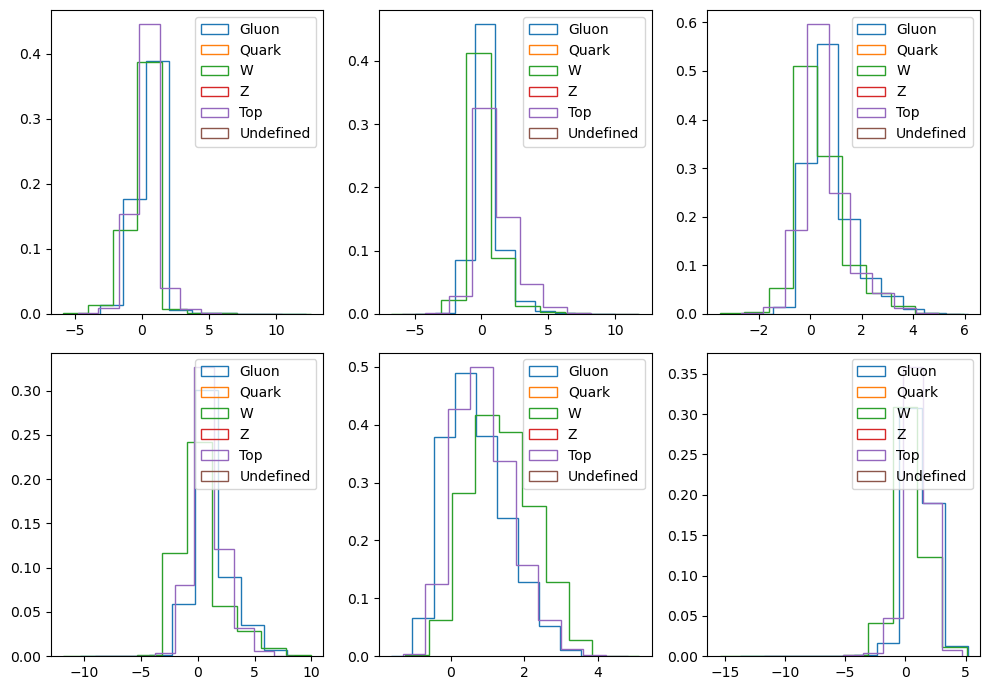

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(10,7), tight_layout=True)
ax = ax.flatten()

for i in range(latent_dim):
    for j in range(len(labels_str)):
        ax[i].hist(latent_jets[labels[:,j]==1, i], label=labels_str[j], histtype='step', density=True)
    ax[i].legend()

In [12]:
fig.savefig('latent_features_hist.pdf')

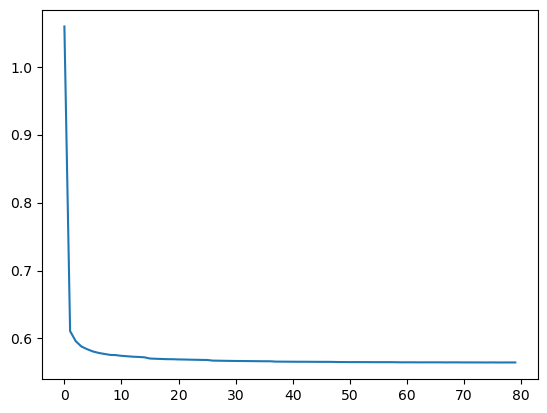

In [39]:
loss = np.load('trainloss_history.npy')
plt.plot(np.arange(len(loss)), loss)

## T_SNE

In [40]:
from tsne_torch import TorchTSNE as TSNE

In [42]:
latent_jets.shape

torch.Size([676304, 6])

In [57]:
X = latent_jets[:5000]
lbl = labels[:5000]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...
100%|██████████| 5000/5000 [00:31<00:00, 156.52it/s]
fitting...
error: 0.968: 100%|██████████| 1000/1000 [00:06<00:00, 153.74it/s]


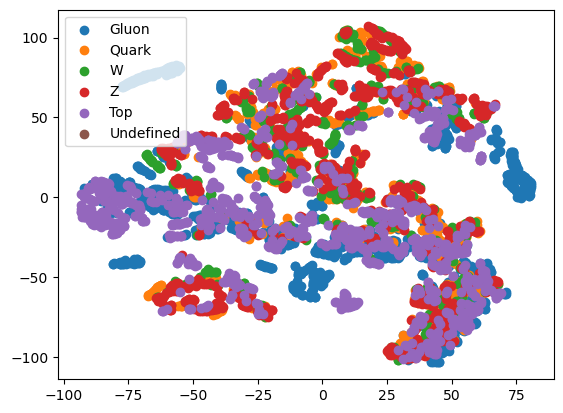

In [58]:
for j in lbl_2_load:
    X_plt = X_emb[lbl[:,j]==1, :]
    plt.scatter(X_plt[:,0], X_plt[:,1], label=labels_str[j])
plt.legend()